# Machine Learning Final Project



Group: Put people's names and aliases here

## Understanding the data

### 0. Importing libraries

In [1]:
# only run if you do not have the library yet
!pip install pytorch-pretrained-bert

    100% |████████████████████████████████| 133kB 2.6MB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 61kB 7.3MB/s 
  Using cached https://files.pythonhosted.org/packages/4e/9e/b956e48125b2034705841f2040d07374748bec107c46de07555f6b97774a/regex-2020.11.13-cp36-cp36m-macosx_10_9_x86_64.whl
    100% |████████████████████████████████| 71kB 3.2MB/s 
    100% |████████████████████████████████| 133kB 4.7MB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 143kB 5.5MB/s 
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 143kB 3.5MB/s 
    100% |████████████████████████████████| 153kB 4.7MB/s 
  Cache entry deserialization failed, entry ignored
  Cache entry deserialization failed, entry ignored
    100% |████████████████████████████████| 61kB 8.9MB/s 
    100% |████████████████████████████████| 71

In [2]:
# only run if you do not have the library yet
!pip install lime

    100% |████████████████████████████████| 276kB 2.6MB/s 
  Using cached https://files.pythonhosted.org/packages/17/1f/bea69a3a5d7efb0e22993d08c4328678e5f6a513cad55247142be8473142/scikit_image-0.17.2-cp36-cp36m-macosx_10_13_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/28/cd/0d96e765d793ae0e2fa291250ab98c27c0c574b0044c5a6ec3f6ae2afa91/PyWavelets-1.1.1-cp36-cp36m-macosx_10_9_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/9b/cd/dc52755d30ba41c60243235460961fc28022e5b6731f16c268667625baea/networkx-2.5-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/6e/57/5d899fae74c1752f52869b613a8210a2480e1a69688e65df6cb26117d45d/imageio-2.9.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/42/6b/93a8ee61c6fbe20fa9c17928bd3b80484902b7fd454cecaffba42f5052cb/tifffile-2020.9.3-py3-none-any.whl
  Running setup.py bdist_wheel for lime ... done
  Stored in directory: /Users/olhakaraiman/Library/Caches/pip/wheels/4c/4f/a5/0b

In [3]:
## Importing the libraries we will use
import pandas as pd
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
import lime.lime_tabular
import nltk
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
import seaborn as sn
from imblearn.over_sampling import SMOTE
from collections import Counter
import requests
import pickle
%matplotlib inline

Using TensorFlow backend.


In [5]:
# Run only once

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/olhakaraiman/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

### 1. Load the data
We will load the data into a pandas dataframe. The tsv file can be obtained in the python script in the group's github repo.

In [6]:
## Reading the data
X_raw = pd.read_csv('/Users/olhakaraiman/Downloads/ML-Fall2020-Final-Project-main/all_data_preprocessed.tsv',  sep='\t')
## Observing how the data looks like
print("Data before preprocessing")
print(X_raw.iloc[0])

Data before preprocessing
id                                                    1313033565513236485
text                    RT DHFM Shweta Next level promotion Thank u Sr...
author_id                                              824473843402240000
retweet_count                                                          48
reply_count                                                             0
like_count                                                              0
quote_count                                                             0
mentions                                    ['DHFM_Shweta', 'SrBachchan']
mentions_count                                                          2
hashtags                                         SarkaruVaariPaata Master
label                                                                   0
author_followers                                                      614
processed_text            Next level promotion Thank u Follow me Master t
hashtags_tfi

### 2. Some pre-processing
Definition of some functions to help us process the data

In [7]:
def filterSencences(sentence):
  '''
  This function tokenizes the sentences for the use with bert
  Input:
    sentence: the sentence to be tokenized
  '''

  ## Erasing nonwords from text
  words = set(nltk.corpus.words.words())
  sent = " ".join(w for w in nltk.wordpunct_tokenize(sentence) if w.lower() in words)

  return sent

In [8]:
def getLen(list_input):
  return len(list_input)

In [9]:
BEARER_TOKEN = ""
headers = {"Authorization": "Bearer {}".format(BEARER_TOKEN)}

def getUserNumOfFollowers(df):
  userIds = df["author_id"].tolist()
  index = 0
  step = 100
  while len(userIds) > index:
    end_index = index + step
    ids = []

    if end_index >= len(userIds):
      ids = userIds[index:]
    else:
      ids = userIds[index:end_index]

    inputs = {'ids': ','.join(str(e) for e in ids), 'user.fields': 'public_metrics'}
    response = requests.get("https://api.twitter.com/2/users", headers=headers,
                            params=inputs)
    if response.status_code != 200:
        raise Exception(
            "Cannot get stream (HTTP {}): {}".format(
                response.status_code, response.text
            )
        )
    data_root = response.json()
    data_list = data_root['data']
    for item in data_list:
      cur_id = item['id']
      df.loc[df['author_id'] == int(cur_id), 'author_followers'] = item['public_metrics']['followers_count']
    index = end_index
  return df

In [10]:
# Getting the number of mentions
X_raw["mentions_count"] = X_raw["mentions"].apply(getLen)

In [11]:
# Process the text to eliminate invalid characters and nonwords
X_raw["processed_text"] = X_raw["text"].apply(filterSencences)

In [ ]:
# Get the number of followers
X_raw["author_followers"] = 0
X_raw = getUserNumOfFollowers(X_raw)

In [12]:
# Getting the tfidf from the text
vec = TfidfVectorizer()
vec_result = vec.fit_transform(X_raw["processed_text"])
root_text_data = pd.DataFrame(vec_result.toarray(), columns=vec.get_feature_names())

X_raw["text_tfid_sum"] = root_text_data.sum(axis=1)
X_raw["text_tfid_max"] = root_text_data.max(axis=1)
X_raw["text_tfid_min"] = root_text_data.min(axis=1)
X_raw["text_tfid_avg"] = root_text_data.mean(axis=1)
X_raw["text_tfid_std"] = root_text_data.std(axis=1)

# Getting the tfidf from the hashtags
vec_hash = TfidfVectorizer()
X_raw["hashtags"] = X_raw["hashtags"].fillna("")
vec_result_hash = vec_hash.fit_transform(X_raw["hashtags"])
root_hash_data = pd.DataFrame(vec_result_hash.toarray(), columns=vec_hash.get_feature_names())

X_raw["hashtag_tfid_sum"] = root_hash_data.sum(axis=1)
X_raw["hashtag_tfid_max"] = root_hash_data.max(axis=1)
X_raw["hashtag_tfid_min"] = root_hash_data.min(axis=1)
X_raw["hashtag_tfid_avg"] = root_hash_data.mean(axis=1)
X_raw["hashtag_tfid_std"] = root_hash_data.std(axis=1)


In [13]:
# Extracting only the numeric data
numeric_data = X_raw[["retweet_count", "like_count", "reply_count", "quote_count", "mentions_count", "label", "sentiment_score_comp", "sentiment_score_pos", "sentiment_score_neg", "sentiment_score_neu", "author_followers", "text_tfid_sum", "text_tfid_max", "text_tfid_min", "text_tfid_avg", "text_tfid_std", "hashtag_tfid_sum", "hashtag_tfid_max", "hashtag_tfid_min", "hashtag_tfid_avg", "hashtag_tfid_std"]]                         

In [14]:
# Saving the data into a file
numeric_data.to_csv("numeric_data.csv", index=False) 

In [15]:
# Shortcut - Uncoment if you want to start off with the numeric data
numeric_data = pd.read_csv('./numeric_data.csv')

In [ ]:
print("Data after preprocessing")
print(numeric_data.iloc[0])

### 3. How the data looks like


Data visualisation:

Word Clouds for tweets with more replies and for tweets with more retweets.

Common language: For tweets with more replies:

Love, girl, guy,god, fan, live, pretty, honesty, birthday, congrats
shut, hell, hate, f*king, shut, covid, vaccine, US, UK, government, exuse
For tweets with more retweets:

Respect, show, goal, artist, youth, win, love, million,help, prize, angel, heart, support, home
Trump, Army, f*ck,die, muslim, power, hate

In [45]:
# Import packages
import matplotlib.pyplot as plt
%matplotlib inline
# Define a function to plot word cloud
def plot_cloud(wordcloud, title):
    # Set figure size
    plt.figure(figsize=(10, 15))
    # Display image
    plt.imshow(wordcloud) 
    plt.title(title)
    # No axis details
    plt.axis("off");

from wordcloud import WordCloud, STOPWORDS
# Generate word cloud
from collections import Counter
results = Counter()
text_label_1 = X_raw.loc[X_raw["label"] == 1, "text"]
text_label_1 = set(' '.join(text_label_1).split())


text_label_0 = X_raw.loc[X_raw["label"] == 0, "text"]
text_label_0 = set(' '.join(text_label_0).split())


wordcloud = WordCloud(width = 750, height = 500, random_state=1, background_color='white', max_words=250, collocations=False, stopwords = STOPWORDS).generate(' '.join(text_label_1))
# Plot
wordcloud1 = WordCloud(width = 750, height = 500, random_state=1, background_color='white',
                      collocations=False, max_words=250, stopwords = STOPWORDS).generate(' '.join(text_label_0))

plot_cloud(wordcloud, "Word cloud for tweets with more replies")
plot_cloud(wordcloud1,"Word cloud for tweets with more retweets")

ModuleNotFoundError: No module named 'wordcloud'

Data visualisation: Sentiment score

Sentiment analysis of tweets with more retweets than replies

Text(0.06837585844212091, 10492.335, 'Mean neg: 0.06')

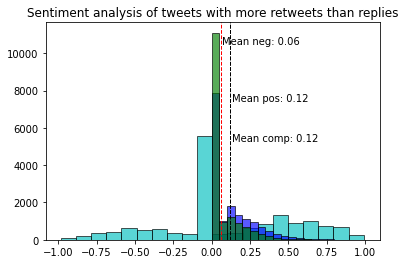

In [28]:
sentiment_label_0_comp = X_raw.loc[X_raw["label"] == 0, "sentiment_score_comp"]
sentiment_label_0_pos = X_raw.loc[X_raw["label"] == 0, "sentiment_score_pos"]
sentiment_label_0_neg = X_raw.loc[X_raw["label"] == 0, "sentiment_score_neg"]

result = plt.hist(sentiment_label_0_comp, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.title("Sentiment analysis of tweets with more retweets than replies")
plt.axvline(sentiment_label_0_comp.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_0_comp.mean()*1.1, max_ylim*0.9, 'Mean comp: {:.2f}'.format(sentiment_label_0_comp.mean()))


result1 = plt.hist(sentiment_label_0_pos, bins=20, color='b', edgecolor='k', alpha=0.65)
plt.axvline(sentiment_label_0_pos.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_0_pos.mean()*1.1, max_ylim*0.9, 'Mean pos: {:.2f}'.format(sentiment_label_0_pos.mean()))

result2 = plt.hist(sentiment_label_0_neg, bins=20, color='g', edgecolor='k', alpha=0.65)
plt.axvline(sentiment_label_0_neg.mean(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_0_neg.mean()*1.1, max_ylim*0.9, 'Mean neg: {:.2f}'.format(sentiment_label_0_neg.mean()))

Sentiment analysis of tweets with more replies than retweets

Text(0.08143832335329343, 1146.285, 'Mean neg: 0.07')

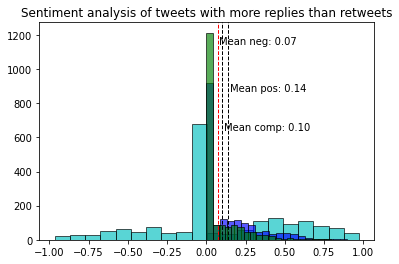

In [29]:
sentiment_label_1_comp = X_raw.loc[X_raw["label"] == 1, "sentiment_score_comp"]
sentiment_label_1_pos = X_raw.loc[X_raw["label"] == 1, "sentiment_score_pos"]
sentiment_label_1_neg = X_raw.loc[X_raw["label"] == 1, "sentiment_score_neg"]

result = plt.hist(sentiment_label_1_comp, bins=20, color='c', edgecolor='k', alpha=0.65)
plt.title("Sentiment analysis of tweets with more replies than retweets")
plt.axvline(sentiment_label_1_comp.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_1_comp.mean()*1.1, max_ylim*0.9, 'Mean comp: {:.2f}'.format(sentiment_label_1_comp.mean()))


result1 = plt.hist(sentiment_label_1_pos, bins=20, color='b', edgecolor='k', alpha=0.65)
plt.axvline(sentiment_label_1_pos.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_1_pos.mean()*1.1, max_ylim*0.9, 'Mean pos: {:.2f}'.format(sentiment_label_1_pos.mean()))

result2 = plt.hist(sentiment_label_1_neg, bins=20, color='g', edgecolor='k', alpha=0.65)
plt.axvline(sentiment_label_1_neg.mean(), color='r', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(sentiment_label_1_neg.mean()*1.1, max_ylim*0.9, 'Mean neg: {:.2f}'.format(sentiment_label_1_neg.mean()))

From the table below, we can see a small difference in sentiment scores for tweets with more replies than retweets.
We can see that tweets with more replis have higher positive and negative sentiment scores, which can potentially mean that tweets with more replies are more controversial than tweets with retweets

|Mean setiment| More replies - label 1  | More retweets - label 0 |
|------|------|------|
|   Positive  | 0.14| 0.12|
|   Negative  | 0.07| 0.06|
|   Compound  | 0.10| 0.12|


**Data visualisation**: Likes 

Tweets with more replies have a little more likes on average

|| More replies - label 1  | More retweets - label 0 |
|------|------|------|
|   Mean likes count | 2.73| 2.59|


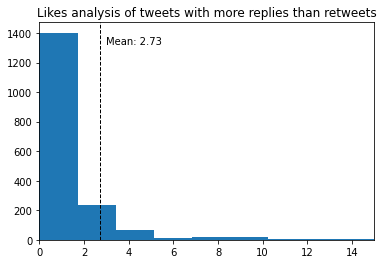

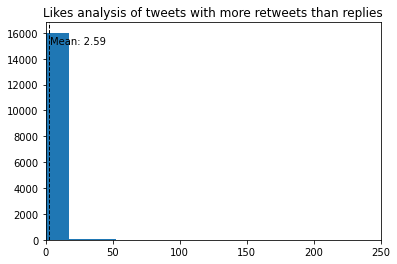

In [30]:
likes_label_1 = X_raw.loc[X_raw["label"] == 1, "like_count"]
likes_label_0  = X_raw.loc[X_raw["label"] == 0, "like_count"]

plt.hist(likes_label_1, bins=150)
plt.title("Likes analysis of tweets with more replies than retweets")
plt.axvline(likes_label_1.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlim(xmin=0, xmax = 15)

min_ylim, max_ylim = plt.ylim()
plt.text(likes_label_1.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(likes_label_1.mean()))
plt.show()


plt.hist(likes_label_0, bins=800)
plt.title("Likes analysis of tweets with more retweets than replies")
plt.axvline(likes_label_0.mean(), color='k', linestyle='dashed', linewidth=1)
plt.xlim(xmin=0, xmax = 250)

min_ylim, max_ylim = plt.ylim()
plt.text(likes_label_0.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(likes_label_0.mean()))
plt.show()

In [53]:
def plotNormalDistribution(mu, sigma, title):
  x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
  plt.plot(x, stats.norm.pdf(x, mu, sigma))
  plt.title(title)
  plt.show()

In [ ]:
def plotData(data, title):
  plt.hist(data, bins=50)
  plt.gca().set(title=title, ylabel='Frequency')
  plt.show()

In [ ]:
## Compute the freqencies of the features
for column_name in numeric_data.columns:
  plotData(numeric_data[column_name], column_name)


In [17]:
# Compute features stats
result_dict = {}

for column_name in numeric_data.columns:
  avg_name = column_name + "_avg"
  std_name = column_name + "_std"
  result_dict[avg_name] = numeric_data[column_name].mean()
  result_dict[std_name] = numeric_data[column_name].std()

In [ ]:
## Print feature stats
feature_stats_df = pd.DataFrame(result_dict, index=[0])
print("-- Full analysis --")
print(feature_stats_df.iloc[0])
print("")

-- Plots Assuming Normal Distribution --


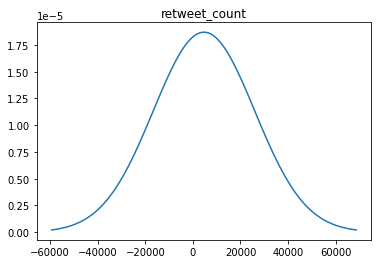

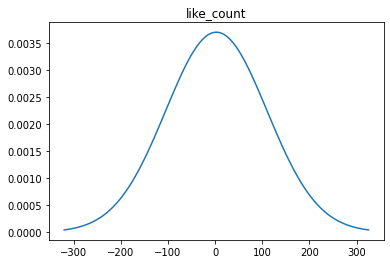

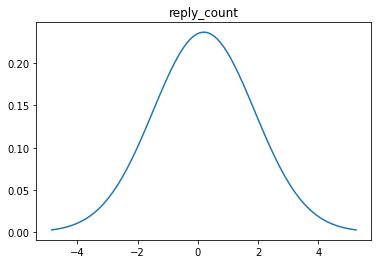

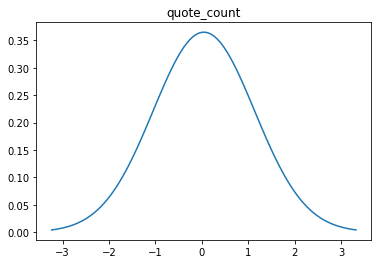

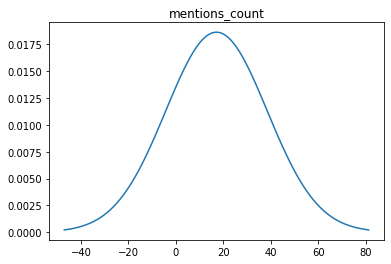

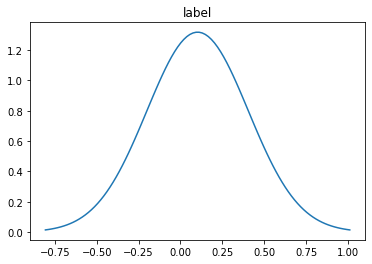

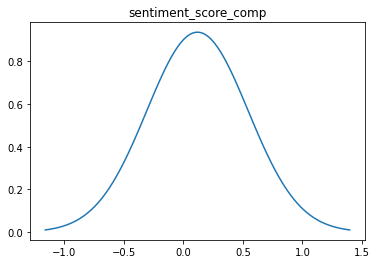

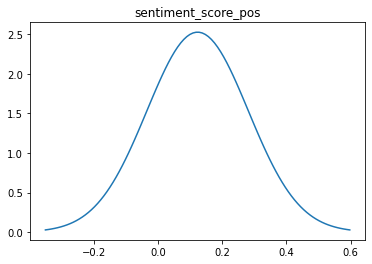

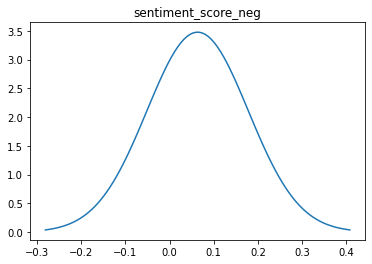

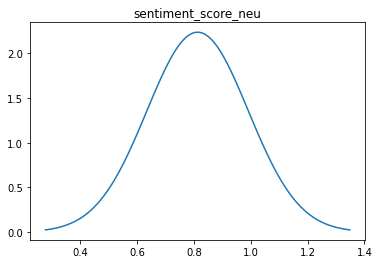

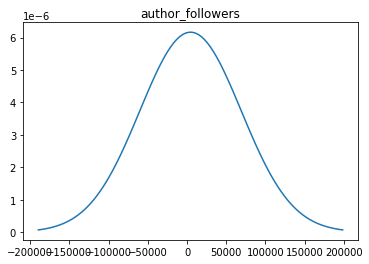

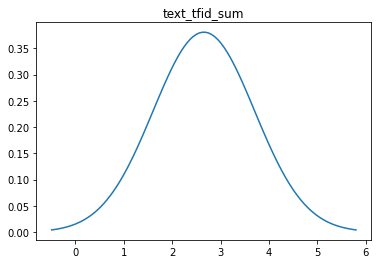

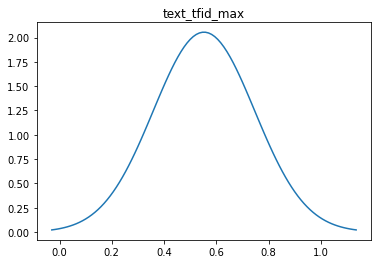

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


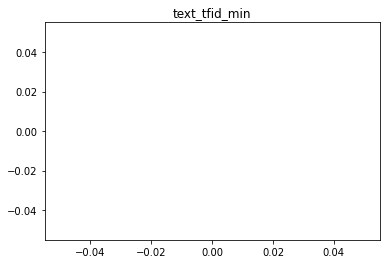

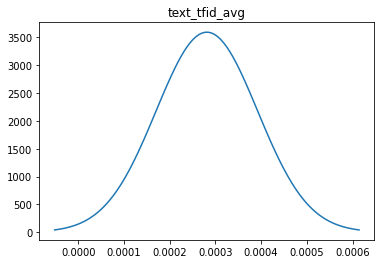

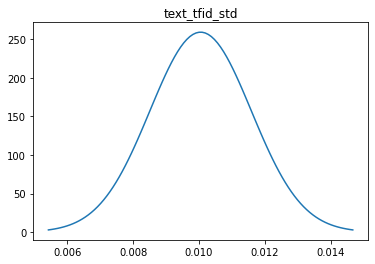

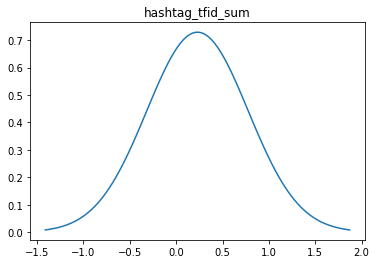

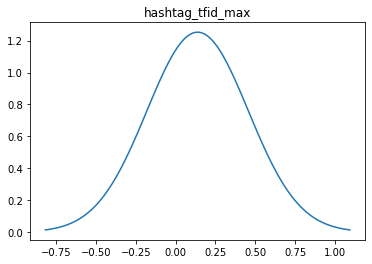

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in greater_equal
  return (a <= x) & (x <= b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:899: RuntimeWarning: invalid value encountered in less_equal
  return (a <= x) & (x <= b)


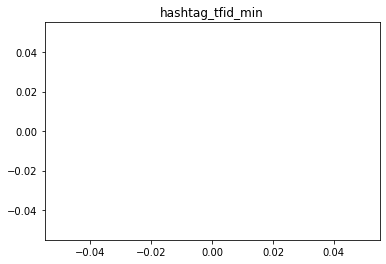

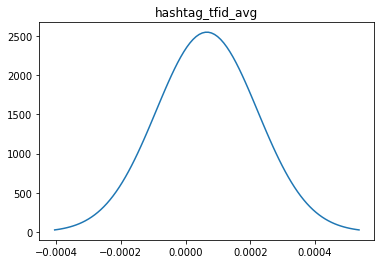

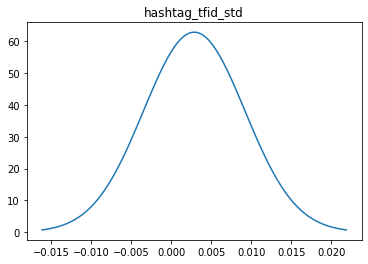

In [19]:
print("-- Plots Assuming Normal Distribution --")

for column_name in numeric_data.columns:
  avg_name = column_name + "_avg"
  std_name = column_name + "_std"
  plotNormalDistribution(result_dict[avg_name], result_dict[std_name], column_name)


In [ ]:
## Correlation Analysis
corrMatrix = numeric_data.corr()
plt.figure(figsize=(17, 12))
sn.heatmap(corrMatrix, annot=True)
plt.show()

### Basic Feature Selection

In [6]:
def removeConstantFeatures(df, print_constant_columns=False):
  constant_filter = VarianceThreshold(threshold=0)
  constant_filter.fit(df)
  constant_columns = [column for column in df.columns if column not in df.columns[constant_filter.get_support()]]
  if print_constant_columns:
    for column in constant_columns:
      print(column)
  df = df.drop(constant_columns, axis=1)

  return df

In [7]:
numeric_data = removeConstantFeatures(numeric_data, True)

text_tfid_min
hashtag_tfid_min


### Handling Imbalanced Data

In [8]:
def balance_data(x_data, y_data):
  smote = SMOTE()

  # fit predictor and target variable
  x_smote, y_smote = smote.fit_resample(x_data, y_data)
  return (pd.DataFrame(x_smote, columns=x_data.columns), y_smote)

Training examples: 10800
Testing examples: 3600
Validation examples: 3600


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


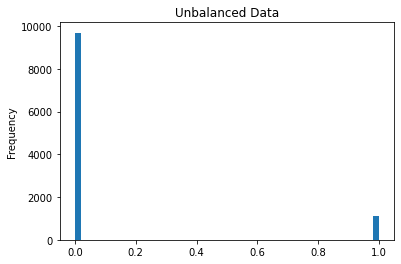

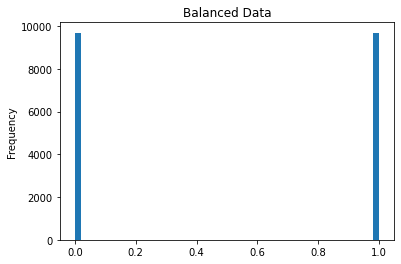

In [9]:
#numeric_data = numeric_data.drop(["retweet_count", "like_count"], axis=1)
y_data_root = numeric_data["label"]    
x_data_root = numeric_data.drop(['label'], axis=1)
X_train_root, X_test, y_train_root, y_test = train_test_split(x_data_root, y_data_root, test_size=0.2, random_state=0)
X_train_root, X_val, y_train_root, y_val = train_test_split(X_train_root, y_train_root, test_size=0.25, random_state=0)

print(f'Training examples: {X_train_root.shape[0]}\nTesting examples: {X_test.shape[0]}\nValidation examples: {X_val.shape[0]}')
X_train, y_train = balance_data(X_train_root, y_train_root)
plotData(y_train_root, "Unbalanced Data")
plotData(y_train, "Balanced Data")

In [33]:
# Saving progress
X_train["label"] = y_train
X_test["label"] = y_test
X_val["label"] = y_val
X_train.to_csv("X_train_upsampled.csv", index=False) 
X_test.to_csv("X_test.csv", index=False)
X_val.to_csv("X_val.csv", index=False) 
X_train = X_train.drop(['label'], axis=1)
X_test = X_test.drop(['label'], axis=1)
X_val = X_val.drop(['label'], axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Part 2: Linear Model

In [10]:
def calculate_scores(model, xtest, ytest):
  pred = model.predict(xtest)
  f1 = f1_score(ytest, pred)
  precision = precision_score(ytest, pred)
  recall = recall_score(ytest, pred, average="binary")
  accuracy = accuracy_score(ytest, pred)
  scores = {"f1": f1, "precision":precision, "recall": recall, "accuracy": accuracy}
  scores_df = pd.DataFrame(scores, index=[0])
  print(scores_df)


In [11]:
def modelExplainability(model, xtrain):
  explainer = lime.lime_tabular.LimeTabularExplainer(xtrain.values,feature_names=xtrain.columns.values.tolist(), class_names=[0, 1])
  predict_fn = lambda x: model.predict_proba(x).astype(float)
  exp = explainer.explain_instance(X_test.values[0], predict_fn, num_features=6)
  exp.show_in_notebook(show_all=False)

In [12]:
def save_model(model, name):
  pickle.dump(model, open(name, 'wb'))

In [ ]:
def load_model(name):
  loaded_model = pickle.load(open(name, 'rb'))
  return loaded_model

In [15]:
reg = LogisticRegression().fit(X_train, y_train)
calculate_scores(reg, X_test, y_test)

        f1  precision  recall  accuracy
0  0.40625   0.254902     1.0  0.704444


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:
modelExplainability(reg, X_train)

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

for name, clf in zip(names, classifiers):
  print("---" + name + "---\n") 
  file_name = name + ".sav"
  clf.fit(X_train, y_train)
  save_model(clf, file_name)
  calculate_scores(clf, X_test, y_test)

---Nearest Neighbors---

         f1  precision   recall  accuracy
0  0.362153   0.257541  0.60989  0.782778
---Linear SVM---

         f1  precision    recall  accuracy
0  0.891892   0.806667  0.997253  0.975556
---RBF SVM---

         f1  precision   recall  accuracy
0  0.058667        1.0  0.03022  0.901944
---Gaussian Process---



## Part 4: Is the project ethical?

<font color='blue'>
    Some discuttion here
</font>